In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [3]:
!pip install pycaret

     |████████████████████████████████| 301 kB 18.7 MB/s            
     |████████████████████████████████| 24.2 MB 23.1 MB/s            
     |████████████████████████████████| 636 kB 42.7 MB/s            
     |████████████████████████████████| 25.9 MB 21.3 MB/s            
     |████████████████████████████████| 114 kB 39.2 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 10.4 MB 22.6 MB/s            
     |████████████████████████████████| 167 kB 39.1 MB/s            
     |████████████████████████████████| 15.6 MB 41.7 MB/s            
     |████████████████████████████████| 184 kB 37.9 MB/s            
     |████████████████████████████████| 1.0 MB 33.0 MB/s            
     |████████████████████████████████| 14.8 MB 19.4 MB/s            
     |████████████████████████████████| 58 kB 7.2 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 79 kB 11.6 MB/s            
  Created wheel fo

In [4]:
from pycaret.regression import *

In [5]:
#import modules
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
from sklearn.preprocessing import LabelEncoder,FunctionTransformer
from sklearn.metrics import r2_score
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
%matplotlib inline

In [6]:
KAGGLE=False

In [7]:
if KAGGLE:
    path='../input/jobathonfebruary2022/'
else:
    path=''

In [8]:
train = pd.read_csv(path+'train_0OECtn8.csv')
test = pd.read_csv(path+'test_1zqHu22.csv')
subm = pd.read_csv(path+'sample_submission_JPlpRcN.csv')

In [9]:
print(train.shape)
print(test.shape)

(89197, 10)
(11121, 9)


In [10]:
# def ordinal_dummy_coding(data,cols):
#     data_updated = data.copy()
#     for col in cols:
#         enc_unique = np.sort(data[col].unique())
#         start_enc = enc_unique[0]
#         data_updated = pd.get_dummies(data_updated,columns = [col], prefix=[col])
#         print('after_dummy_update:',data_updated.columns)
#         print('after_dummy_update:',data_updated.head())
#         for enc_val in enc_unique:
#             #remove 1st dummy variable since it will become constant value
#             #as all higher values of 1 will always update it to 1

#             dummy_col = col+'_'+str(enc_val)
#             if enc_val==start_enc:
#                 del data_updated[dummy_col]
#                 continue
                
#             mask = data_updated[dummy_col]==1
#             for prior_enc in range(start_enc+1,enc_val):
#                 prior_dummy_col = col+'_'+str(prior_enc)
#                 data_updated[prior_dummy_col][mask] = 1
            
#     return data_updated    

In [11]:
# print(np.sort(train['followers'].unique()))
# print(np.sort(test['followers'].unique()))

In [12]:
# keys = np.sort(train['followers'].unique())
# values = range(train['followers'].nunique())
# followers_map = dict(zip(keys, values))
# print(followers_map) 

In [13]:
# train['istrain']=1
# test['istrain']=0

# combined = pd.concat([train,test],axis=0)

In [14]:
# combined['followers'] = combined['followers'].replace(followers_map)
# combined= ordinal_dummy_coding(combined,['followers'])

In [15]:
# train= combined[combined['istrain']==1]
# test= combined[combined['istrain']==0]

# del combined,train['istrain'],test['istrain']

In [16]:
print(train.columns)
print(test.columns)

Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views', 'engagement_score'],
      dtype='object')
Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views'],
      dtype='object')


In [17]:
def preproc(train,test):
    label_encoder = LabelEncoder()

    train['gender']= label_encoder.fit_transform(train['gender'])
    test['gender']= label_encoder.transform(test['gender'])
    
    #ordinal encoding of profession
    prof_map = {'Other':0,'Student':1,'Working Professional':2}
    train['profession'] = train['profession'].map(prof_map)
    test['profession'] = test['profession'].map(prof_map)
    
    #to have video id without target encoding
    train['video_id_raw']=train['video_id'].copy()
    
def gen_agg(train,test):
    #user_id aggregate features
    user_agg = train[['user_id','video_id','category_id']].groupby('user_id').agg('nunique').reset_index()
    user_agg = user_agg.rename({'video_id':'user_video_count','category_id':'user_category_count'},axis=1)
    train = pd.merge(train, user_agg, how='left', on='user_id')
    test = pd.merge(test, user_agg, how='left', on='user_id')
    
    
    #category_id aggregate features
    cat_agg = train[['category_id','user_id','video_id','age','gender','profession']] \
                        .groupby('category_id') \
                        .agg({'user_id':'nunique','video_id':'nunique', \
                             'age':'mean','gender':'mean','profession':'mean'}) \
                        .reset_index()
    cat_agg = cat_agg.rename({'user_id':'category_user_count',
                              'video_id':'category_video_count',
                              'age':'category_age_mean',
                              'gender':'category_gender_mean',
                              'profession':'category_profession_mean',
                             }, axis=1)
    train = pd.merge(train, cat_agg, how='left', on='category_id')
    test = pd.merge(test, cat_agg, how='left', on='category_id')    
    
    #video_id aggregate features
    video_agg = train[['video_id','age','gender','profession']] \
                        .groupby('video_id') \
                        .agg('mean') \
                        .reset_index() 
    video_agg = video_agg.rename({'age':'video_age_mean',
                              'gender':'video_gender_mean',
                              'profession':'video_profession_mean',
                             },axis=1)
    train = pd.merge(train, video_agg, how='left', on='video_id')
    test = pd.merge(test, video_agg, how='left', on='video_id')
    
    return train,test
        

In [18]:
preproc(train,test)

In [19]:
train,test = gen_agg(train,test)

In [20]:
print(train.columns)
train.head()

Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views', 'engagement_score', 'video_id_raw',
       'user_video_count', 'user_category_count', 'category_user_count',
       'category_video_count', 'category_age_mean', 'category_gender_mean',
       'category_profession_mean', 'video_age_mean', 'video_gender_mean',
       'video_profession_mean'],
      dtype='object')


,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score,video_id_raw,user_video_count,user_category_count,category_user_count,category_video_count,category_age_mean,category_gender_mean,category_profession_mean,video_age_mean,video_gender_mean,video_profession_mean
0,1,19990,37,128,24,1,1,180,1000,4.33,128,3,2,635,2,24.816008,0.602911,0.922037,24.864811,0.602386,0.912525
1,2,5304,32,132,14,0,1,330,714,1.79,132,5,3,1507,4,24.884218,0.563053,0.862832,25.104735,0.569584,0.892396
2,3,1840,12,24,19,1,1,180,138,4.35,24,3,1,2020,6,24.836205,0.670352,0.883775,25.039640,0.681081,0.935135
3,4,12597,23,112,19,1,1,220,613,3.77,112,3,2,1705,2,25.175964,0.642456,0.897791,25.248317,0.641735,0.893044
4,5,13626,23,112,27,1,2,220,613,3.13,112,4,2,1705,2,25.175964,0.642456,0.897791,25.248317,0.641735,0.893044


In [21]:
targetcol = 'engagement_score'
target = train[targetcol]

In [22]:
exclude_cols =['row_id', 'category_age_mean', 'category_gender_mean',
       'category_profession_mean',  'video_gender_mean',
       'video_profession_mean','video_id_raw',
            'video_age_mean',
        'video_age_ratio', 'video_profession_diff', 
        'video_profession_ratio', 'video_gender_diff', 'video_gender_ratio']
features =[col for col in train.columns if col not in exclude_cols]
print(len(features))
print(features)
features_excl_target = [col for col in features if col!=targetcol]

13
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'engagement_score', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count']


In [23]:
catcols = []
numeric_cols = [col for col in features if col not in catcols+[targetcol]]
print(len(catcols))
print(catcols)
print(len(numeric_cols))
print(numeric_cols)

0
[]
12
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count']


In [24]:
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.woe import WOEEncoder

In [25]:

ct = ColumnTransformer(
     [
         ("targetenc",  TargetEncoder(cols=['user_id','category_id', 'video_id'],
                                                min_samples_leaf=2, smoothing=0.1) , ['user_id','category_id', 'video_id']),
#       ("helmertenc",  HelmertEncoder() , ['followers']),
#     ("targetenc2",  TargetEncoder(cols=['followers'],
#                                                     min_samples_leaf=2, smoothing=0.1) , ['followers']),
#       ("rank",  FunctionTransformer(lambda x: x*10000) , ['followers']),
      ],remainder='passthrough')

# ct2 = ColumnTransformer(
#      [("rank",  FunctionTransformer(lambda x: x.rank()) , ['followers'])
#       ],remainder='passthrough')
preprocessor = ('preproc',ct)

In [26]:
# ct.fit(train,target)
# temp = ct.transform(train)
# temp[0:10,:]

In [27]:
# ce_target=TargetEncoder(cols=['user_id','category_id', 'video_id'],
#                        min_samples_leaf=2, smoothing=0.1)
# ce_target.fit(train,target)

# ret =ce_target.transform(train,target)
# ret.head()

In [28]:
s = setup(train[features], session_id=100,
          silent=True,
          numeric_features=numeric_cols,
          categorical_features=catcols,
          target = targetcol,
          custom_pipeline=preprocessor,
          fold=10,fold_shuffle=False,
          )

,Description,Value
0,session_id,100
1,Target,engagement_score
2,Original Data,"(89197, 13)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(62437, 12)"


In [29]:
X= get_config('X')
print(len(X.columns))
print(list(X.columns))
X.head()

12
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count']


,user_id,category_id,video_id,age,gender,profession,followers,views,user_video_count,user_category_count,category_user_count,category_video_count
0,19990.0,37.0,128.0,24.0,1.0,1.0,180.0,1000.0,3.0,2.0,635.0,2.0
1,5304.0,32.0,132.0,14.0,0.0,1.0,330.0,714.0,5.0,3.0,1507.0,4.0
2,1840.0,12.0,24.0,19.0,1.0,1.0,180.0,138.0,3.0,1.0,2020.0,6.0
3,12597.0,23.0,112.0,19.0,1.0,1.0,220.0,613.0,3.0,2.0,1705.0,2.0
4,13626.0,23.0,112.0,27.0,1.0,2.0,220.0,613.0,4.0,2.0,1705.0,2.0


In [39]:
 params = {
     'subsample': 0.8,
     'colsample_bytree': 0.8,
    'subsample_freq': 15,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
     'max_depth': 12,
    'num_leaves': 30,
    'reg_alpha': 0.3,  
    'reg_lambda': 0.7,
     'n_estimators': 200,
 }

In [40]:
%%time
lgbm = create_model('lightgbm',**params)
lgbm

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5008,0.4672,0.6835,0.4007,0.1924,0.2418
1,0.5030,0.4553,0.6747,0.3828,0.1825,0.2424
2,0.5110,0.4810,0.6935,0.3761,0.1916,0.2826
3,0.5045,0.4596,0.6779,0.3777,0.1849,0.2261
4,0.5034,0.4638,0.6810,0.3883,0.1874,0.1969
5,0.5090,0.4713,0.6865,0.3680,0.1856,0.2252
6,0.4975,0.4454,0.6674,0.3901,0.1789,0.1915
7,0.5031,0.4615,0.6794,0.3867,0.1858,0.2343
8,0.4944,0.4420,0.6648,0.3894,0.1791,0.2392
9,0.5018,0.4595,0.6779,0.3921,0.1872,0.2583


CPU times: user 8.18 s, sys: 79.8 ms, total: 8.26 s
Wall time: 6.56 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              feature_fraction=0.9, importance_type='split', learning_rate=0.05,
              max_depth=12, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=30,
              objective=None, random_state=100, reg_alpha=0.3, reg_lambda=0.7,
              silent='warn', subsample=0.8, subsample_for_bin=200000,
              subsample_freq=15)

[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/pycaret/internal/pipeline.py", line 118, in fit
    result = super().fit(X, y=y, **fit_kwargs)
  File "/opt/conda/lib/python3.7/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py", line 899, in fit
    categorical_feature=categorical_feature, callbacks=callbacks, init_model=init_model)
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py", line 758, in fit
    callbacks=callbacks
  File "/opt/co

[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/pycaret/internal/pipeline.py", line 118, in fit
    result = super().fit(X, y=y, **fit_kwargs)
  File "/opt/conda/lib/python3.7/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py", line 899, in fit
    categorical_feature=categorical_feature, callbacks=callbacks, init_model=init_model)
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py", line 758, in fit
    callbacks=callbacks
  File "/opt/co

[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be i

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/pycaret/internal/pipeline.py", line 118, in fit
    result = super().fit(X, y=y, **fit_kwargs)
  File "/opt/conda/lib/python3.7/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py", line 899, in fit
    categorical_feature=categorical_feature, callbacks=callbacks, init_model=init_model)
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py", line 758, in fit
    callbacks=callbacks
  File "/opt/co

[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/pycaret/internal/pipeline.py", line 118, in fit
    result = super().fit(X, y=y, **fit_kwargs)
  File "/opt/conda/lib/python3.7/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py", line 899, in fit
    categorical_feature=categorical_feature, callbacks=callbacks, init_model=init_model)
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py", line 758, in fit
    callbacks=callbacks
  File "/opt/co

[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value

In [47]:
# tune_params = {"max_depth": np.random.randint(1, (len(data.columns)*.85),20),
#           "max_features": np.random.randint(1, len(train.columns),20),
#           "min_samples_leaf": [20,50,100,500],
#           "criterion": ["gini", "entropy"]
#           }

tune_params = {
    'subsample': np.random.uniform( 0.6, 1, 25),
    'num_leaves': np.random.randint( 20, 150, 5),
    'subsample_for_bin': np.random.randint( 40000, 160000, 10000),
    'min_child_samples': np.random.randint(30, 200, 5),
    'reg_alpha': np.random.uniform( 0.01, 0.99),
    'reg_lambda': np.random.uniform( 0.01, 0.99),
    'colsample_bytree': np.random.uniform(0.6, 1.0),
}

# bagging_freq(subsample_freq), bagging_fraction (subsample), feature_fraction (colsample_bytree)

In [48]:
%%time
tuned_lgbm = tune_model(lgbm,optimize='r2',
                        search_library='scikit-optimize',
                        n_iter=25)
tuned_lgbm

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5028,0.4600,0.6782,0.4100,0.1921,0.2446
1,0.5052,0.4491,0.6702,0.3912,0.1822,0.2436
2,0.5115,0.4730,0.6878,0.3865,0.1911,0.2863
3,0.5045,0.4524,0.6726,0.3874,0.1844,0.2263
4,0.5053,0.4566,0.6757,0.3979,0.1870,0.1990
5,0.5092,0.4607,0.6787,0.3822,0.1846,0.2265
6,0.4978,0.4376,0.6615,0.4007,0.1782,0.1924
7,0.5047,0.4551,0.6746,0.3952,0.1859,0.2363
8,0.4973,0.4333,0.6583,0.4013,0.1782,0.2410
9,0.5049,0.4520,0.6723,0.4019,0.1867,0.2630


CPU times: user 1min 29s, sys: 1min 35s, total: 3min 5s
Wall time: 3min 21s


LGBMRegressor(bagging_fraction=0.9952502960431285, bagging_freq=0,
              boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              feature_fraction=0.4, importance_type='split',
              learning_rate=0.03690482570462122, max_depth=12,
              min_child_samples=100, min_child_weight=0.001,
              min_split_gain=0.2626290916915215, n_estimators=151, n_jobs=-1,
              num_leaves=256, objective=None, random_state=100, reg_alpha=1e-10,
              reg_lambda=0.00696729047618253, silent='warn', subsample=0.8,
              subsample_for_bin=200000, subsample_freq=15)

In [50]:
lgbm_old = lgbm
lgbm= tuned_lgbm

In [54]:
lgbm

LGBMRegressor(bagging_fraction=0.9952502960431285, bagging_freq=0,
              boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              feature_fraction=0.4, importance_type='split',
              learning_rate=0.03690482570462122, max_depth=12,
              min_child_samples=100, min_child_weight=0.001,
              min_split_gain=0.2626290916915215, n_estimators=151, n_jobs=-1,
              num_leaves=256, objective=None, random_state=100, reg_alpha=1e-10,
              reg_lambda=0.00696729047618253, silent='warn', subsample=0.8,
              subsample_for_bin=200000, subsample_freq=15)

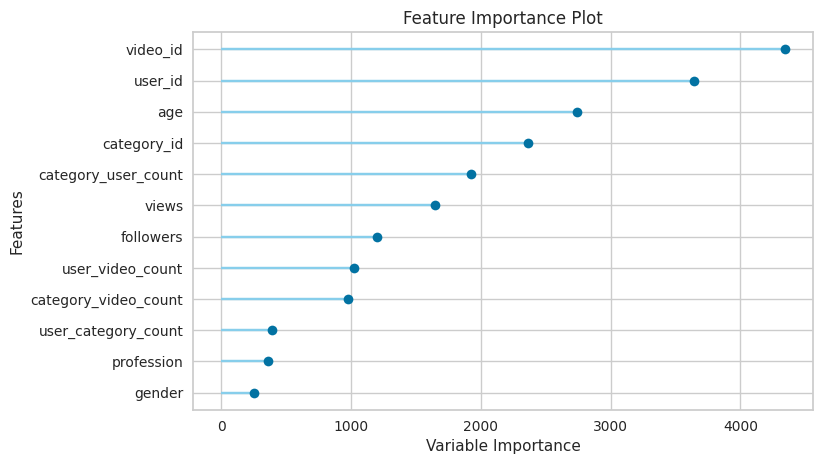

In [51]:
plot_model(lgbm,'feature_all')

In [52]:
%%time
#test predictions
final_model = finalize_model(lgbm)
test_preds = predict_model(final_model, data=test)
print(test_preds.head())


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=15 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.8 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=15 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8202483946835517, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8202483946835517
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=15 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.9338236228617248, subsample=0.8 will be ignored. Current value: bagging_fraction=0.9338236228617248
[LightGBM] [W

In [55]:
final_model

LGBMRegressor(bagging_fraction=0.9952502960431285, bagging_freq=0,
              boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              feature_fraction=0.4, importance_type='split',
              learning_rate=0.03690482570462122, max_depth=12,
              min_child_samples=100, min_child_weight=0.001,
              min_split_gain=0.2626290916915215, n_estimators=151, n_jobs=-1,
              num_leaves=256, objective=None, random_state=100, reg_alpha=1e-10,
              reg_lambda=0.00696729047618253, silent='warn', subsample=0.8,
              subsample_for_bin=200000, subsample_freq=15)

In [53]:
%%time
#train predictions
train_preds = predict_model(final_model, data=train)
print(train_preds.head())
print('full train score:',r2_score(target,train_preds['Label']))

   row_id  user_id  category_id  video_id  age  gender  profession  followers  \
0       1    19990           37       128   24       1           1        180   
1       2     5304           32       132   14       0           1        330   
2       3     1840           12        24   19       1           1        180   
3       4    12597           23       112   19       1           1        220   
4       5    13626           23       112   27       1           2        220   

   views  engagement_score  ...  user_category_count  category_user_count  \
0   1000              4.33  ...                    2                  635   
1    714              1.79  ...                    3                 1507   
2    138              4.35  ...                    1                 2020   
3    613              3.77  ...                    2                 1705   
4    613              3.13  ...                    2                 1705   

   category_video_count  category_age_mean  catego

In [56]:
lgbm

LGBMRegressor(bagging_fraction=0.9952502960431285, bagging_freq=0,
              boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              feature_fraction=0.4, importance_type='split',
              learning_rate=0.03690482570462122, max_depth=12,
              min_child_samples=100, min_child_weight=0.001,
              min_split_gain=0.2626290916915215, n_estimators=151, n_jobs=-1,
              num_leaves=256, objective=None, random_state=100, reg_alpha=1e-10,
              reg_lambda=0.00696729047618253, silent='warn', subsample=0.8,
              subsample_for_bin=200000, subsample_freq=15)

In [58]:
submission = test_preds[['row_id','Label']]
submission=submission.rename(columns={'Label':'engagement_score'})
submission[['row_id','engagement_score']].to_csv('submission.csv',index=False)

In [59]:
test_sub = pd.read_csv('submission.csv')

In [60]:
print(test_sub.shape)
test_sub.head()

(11121, 2)


,row_id,engagement_score
0,89198,4.177116
1,89199,3.959879
2,89200,2.351173
3,89201,2.994933
4,89202,2.321698
